# Predict the fare amount of future rides using regression analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"uber.csv")
df.head()

Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         -73.965316         40.803349                3  
4         -73.973082         40.761247                5

### Explore dataset

In [38]:
print(df.shape)

(199999, 14)


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                199999 non-null  object             
 1   fare_amount        199999 non-null  float64            
 2   pickup_datetime    199999 non-null  datetime64[ns, UTC]
 3   pickup_longitude   199999 non-null  float64            
 4   pickup_latitude    199999 non-null  float64            
 5   dropoff_longitude  199999 non-null  float64            
 6   dropoff_latitude   199999 non-null  float64            
 7   passenger_count    199999 non-null  int64              
 8   hour               199999 non-null  int32              
 9   day                199999 non-null  int32              
 10  day_of_week        199999 non-null  int32              
 11  month              199999 non-null  int32              
 12  distance_km        199999 non-null 

In [83]:
df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  199999.000000     199999.000000    199999.000000      199999.000000   
mean       11.359892        -72.527631        39.935881         -72.525292   
std         9.901760         11.437815         7.720558          13.117408   
min       -52.000000      -1340.648410       -74.015515       -3356.666300   
25%         6.000000        -73.992065        40.734796         -73.991407   
50%         8.500000        -73.981823        40.752592         -73.980093   
75%        12.500000        -73.967154        40.767158         -73.963658   
max       499.000000         57.418457      1644.421482        1153.572603   

       dropoff_latitude  passenger_count           hour            day  \
count     199999.000000    199999.000000  199999.000000  199999.000000   
mean          39.923890         1.684543      13.491387      15.704739   
std            6.794829         1.385995       6.515505       8.687377   
min         -881.985513         0.000000       0.000000       1.000000   
25%           40.733823         1.000000       9.000000       8.000000   
50%           40.753042         1.000000      14.000000      16.000000   
75%           40.768001         2.000000      19.000000      23.000000   
max          872.697628       208.000000      23.000000      31.000000   

         day_of_week          month    distance_km  
count  199999.000000  199999.000000  199999.000000  
mean        3.048435       6.281791      20.855350  
std         1.946946       3.438933     382.964642  
min         0.000000       1.000000       0.000000  
25%         1.000000       3.000000       1.215222  
50%         3.000000       6.000000       2.120992  
75%         5.000000       9.000000       3.875169  
max         6.000000      12.000000   16409.239135

In [6]:
# drop the key columns
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

#### Handle the missing data

In [8]:
print(df.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [9]:
# drop rows with missing values
df = df.dropna()

In [10]:
print(df.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


#### check target variable

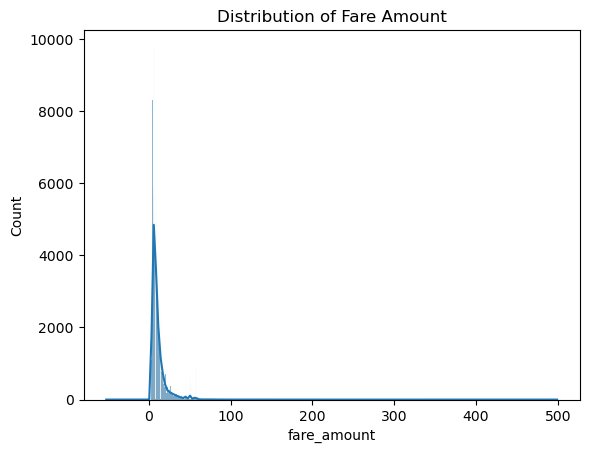

In [11]:
sns.histplot(df["fare_amount"],kde = True)
plt.title("Distribution of Fare Amount")
plt.show()

##### Box plot to check the outliers

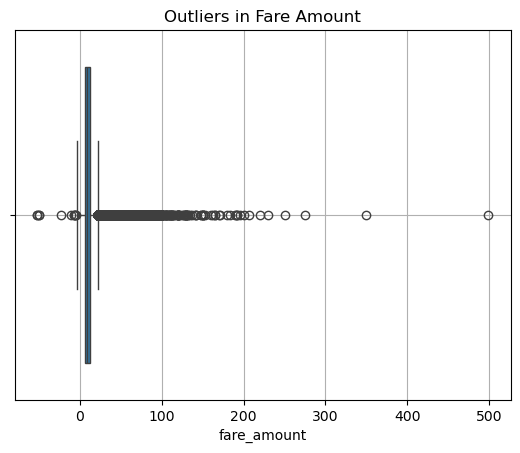

In [12]:
sns.boxplot(x = df["fare_amount"])
plt.title("Outliers in Fare Amount")
plt.grid()
plt.show()

## Featues Engineering

In [40]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["hour"] = df["pickup_datetime"].dt.hour
df["day"] = df["pickup_datetime"].dt.day
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
df["month"] = df["pickup_datetime"].dt.month

In [41]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'hour', 'day', 'day_of_week', 'month', 'distance_km',
       'distance_category'],
      dtype='object')

### Calculate the distance using haversine formula 

In [42]:
from math import radians, sin,cos,sqrt,atan2


In [43]:
def haversine(lat1,lon1,lat2,lon2):
    R = 6371 # Radius of Earth in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2) **2
    return 2 * R * atan2(sqrt(a),sqrt(1-a))
    
df["distance_km"] = df.apply(lambda row: haversine(row["pickup_latitude"],
                                                  row["pickup_longitude"],
                                                  row["dropoff_latitude"],
                                                  row["dropoff_longitude"]),axis = 1 )
    

In [44]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'hour', 'day', 'day_of_week', 'month', 'distance_km',
       'distance_category'],
      dtype='object')

In [45]:
# Categorize Distance
df["distance_category"] = pd.cut(df["distance_km"],bins = [0,2,6,20],labels = ["short","median","long"])
df

key  fare_amount           pickup_datetime  \
0         2015-05-07 19:52:06.0000003          7.5 2015-05-07 19:52:06+00:00   
1         2009-07-17 20:04:56.0000002          7.7 2009-07-17 20:04:56+00:00   
2        2009-08-24 21:45:00.00000061         12.9 2009-08-24 21:45:00+00:00   
3         2009-06-26 08:22:21.0000001          5.3 2009-06-26 08:22:21+00:00   
4       2014-08-28 17:47:00.000000188         16.0 2014-08-28 17:47:00+00:00   
...                               ...          ...                       ...   
199995   2012-10-28 10:49:00.00000053          3.0 2012-10-28 10:49:00+00:00   
199996    2014-03-14 01:09:00.0000008          7.5 2014-03-14 01:09:00+00:00   
199997   2009-06-29 00:42:00.00000078         30.9 2009-06-29 00:42:00+00:00   
199998    2015-05-20 14:56:25.0000004         14.5 2015-05-20 14:56:25+00:00   
199999   2010-05-15 04:08:00.00000076         14.1 2010-05-15 04:08:00+00:00   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.999817        40.738354         -73.999512   
1             -73.994355        40.728225         -73.994710   
2             -74.005043        40.740770         -73.962565   
3             -73.976124        40.790844         -73.965316   
4             -73.925023        40.744085         -73.973082   
...                  ...              ...                ...   
199995        -73.987042        40.739367         -73.986525   
199996        -73.984722        40.736837         -74.006672   
199997        -73.986017        40.756487         -73.858957   
199998        -73.997124        40.725452         -73.983215   
199999        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  hour  day  day_of_week  month  \
0              40.723217                1    19    7            3      5   
1              40.750325                1    20   17            4      7   
2              40.772647                1    21   24            0      8   
3              40.803349                3     8   26            4      6   
4              40.761247                5    17   28            3      8   
...                  ...              ...   ...  ...          ...    ...   
199995         40.740297                1    10   28            6     10   
199996         40.739620                1     1   14            4      3   
199997         40.692588                2     0   29            0      6   
199998         40.695415                1    14   20            2      5   
199999         40.768793                1     4   15            5      5   

        distance_km distance_category  
0          1.683323             short  
1          2.457590            median  
2          5.036377            median  
3          1.661683             short  
4          4.475450            median  
...             ...               ...  
199995     0.112210             short  
199996     1.875050             short  
199997    12.850319              long  
199998     3.539715            median  
199999     5.417783            median  

[199999 rows x 14 columns]

### Split the Dataset

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
# select features(X) and target(y)
X = df[["distance_km","hour","day_of_week","month","passenger_count"]]
y = df["fare_amount"]


In [48]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [49]:
print(X_train.shape,X_test.shape)

(159999, 5) (40000, 5)


### Data Scaling/ Normalization

In [50]:
from sklearn.preprocessing import StandardScaler

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [85]:
print(X_train_scaled,X_test_scaled)

[[-0.04916947  1.3071289  -1.05273594  0.79152662 -0.48742328]
 [-0.04952449  1.15370658 -1.5663893  -0.37118009 -0.48742328]
 [-0.05087977 -0.53393888  1.00187752 -0.95253344  0.93623406]
 ...
 [-0.0445871  -1.45447277  0.48822415  1.37287998 -0.48742328]
 [-0.0508082  -0.6873612  -0.53908257  0.50084995 -0.48742328]
 [-0.01811843  1.15370658 -1.05273594  1.0822033  -0.48742328]] [[-0.04877897 -1.91473972 -0.53908257 -1.24321012 -0.48742328]
 [-0.0517564   0.23317269  1.51553088 -0.08050341 -0.48742328]
 [-0.04543278  0.54001732  1.00187752 -1.53388679  2.3598914 ]
 ...
 [-0.05180635 -0.07367194 -1.5663893   0.21017327 -0.48742328]
 [-0.04552451  0.69343964 -0.53908257  0.50084995  0.93623406]
 [-0.05030321 -0.84078351 -1.5663893  -0.08050341 -0.48742328]]


## Correlation Analysis

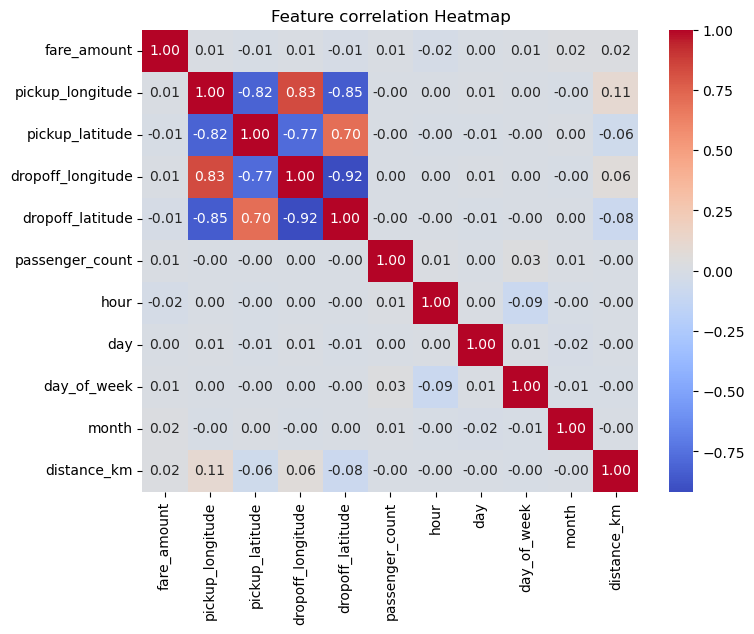

In [53]:
numeric_df = df.select_dtypes(include = ["number"])
corr_matrix = numeric_df.corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm",fmt = ".2f")
plt.title("Feature correlation Heatmap")
plt.show()

### Component 3 : Regression Modeling

To select and train appropriate regression models (Linear Regression, Decision Tree, Random Forest, etc.) using the cleaned and scaled Uber dataset to predict fare amount.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error

#### Prepare the Data

In [57]:
# print(X_train_scaled, X_test_scaled, y_train, y_test)
print(X_train_scaled.shape,y_train.shape)

(159999, 5) (159999,)


### Linear Regression

In [58]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [61]:
y_pred_lr

array([11.36744377, 11.29147207, 11.14101472, ..., 11.28816793,
       11.38495535, 11.37704143])

## Decision Tree Regression

In [63]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled,y_train)
y_pred_dt = dt.predict(X_test_scaled)

In [64]:
y_pred_dt

array([12. ,  5.7,  8.9, ...,  8.9, 23. , 12.5])

## Random Forest Regression

In [65]:
rf = RandomForestRegressor(n_estimators=100,random_state=42)
rf.fit(X_train_scaled,y_train)
y_pred_rf = rf.predict(X_test_scaled)

In [66]:
y_pred_rf

array([ 7.805 ,  5.136 , 10.901 , ...,  6.186 , 13.483 ,  7.7389])

#### Evaluate All Models


In [ ]:
R² Score (how well the model fits)

MAE (Mean Absolute Error)

RMSE (Root Mean Squared Error)

In [67]:
models = {
    "Linear Regression": [y_pred_lr],
    "Decision Tree":[y_pred_dt],
    "Random Forest":[y_pred_rf]
}
for name,preds in models.items():
    r2 = r2_score(y_test,preds[0])
    mae = mean_absolute_error(y_test,preds[0])
    rmse = np.sqrt(mean_absolute_error(y_test,preds[0]))
    print(f"{name}:\n R2 = {r2:.3f}\n MAE = {mae:.2f}\n RMSE = {rmse:.2f}\n")

Linear Regression:
 R2 = 0.001
 MAE = 6.06
 RMSE = 2.46

Decision Tree:
 R2 = 0.386
 MAE = 3.53
 RMSE = 1.88

Random Forest:
 R2 = 0.638
 MAE = 2.68
 RMSE = 1.64



In [68]:
y_pred = rf.predict(X_test)

In [72]:
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
r_2 = r2_score(y_test,y_pred)


In [73]:
print("Model Evaluation Results")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r_2:.3f}")

Model Evaluation Results
MAE: 14.69
MSE: 341.55
RMSE: 18.48
R2 Score: -2.283


### Fine-Tune the Model (Hyperparameter Tuning)

####  Randomized Search (faster)

In [86]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

#### Define the Parameter Grid

These are the hyperparameters that control how your Random Forest learns.

In [87]:
param_grid = {
    "n_estimators":[100,200,300,400,500],
    "max_depth":[5,10,15,20,None],
    "min_samples_split":[2,4,6,8],
    "min_samples_leaf":[1,2,4],
    "bootstrap":[True,False]
}

##### Create the RandomizedSearchCV Object

In [88]:
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1
)

#### Fit on Training Data

In [90]:
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

#### check best parameter

In [92]:
print("Best parameter: ",random_search.best_params_)
print("Best Score: ",random_search.best_score_)



Best parameter:  {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}
Best Score:  0.7433827388813854


#### Evaluate the Tuned Random Forest Model

In [97]:
from sklearn.ensemble import RandomForestRegressor

In [99]:
best_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth = 10,
    min_samples_split=6,
    min_samples_leaf=4,
    bootstrap=True,
    random_state= 42
)
best_rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=6,
                      random_state=42)

#### Make Predictions on the Test Set

In [100]:
y_pred_best = best_rf.predict(X_test)

#### Evaluate with Metrics

In [101]:
r2 = r2_score(y_test,y_pred_best)
mae = mean_absolute_error(y_test,y_pred_best)
rmse = mean_squared_error(y_test,y_pred_best, squared=False)

In [102]:
print(" Test R2 Score: ",r2)
print(" Test MAE :",mae)
print(" Test RMSE: ", rmse)

 Test R2 Score:  0.6776345439134477
 Test MAE : 2.4661286200321477
 Test RMSE:  5.790830938835154
